In [39]:
import os
import random
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import plot_importance, plot_tree

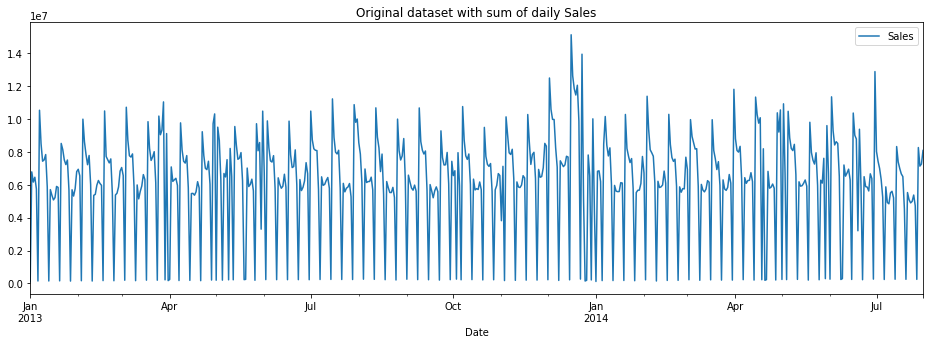

In [2]:
df = pd.read_pickle('clean_data.pkl')

main_df = pd.DataFrame(df.groupby(df['Date'])['Sales'].sum())

main_df.plot(figsize=(16,5))
plt.title('Original dataset with sum of daily Sales')
plt.show()

In [3]:
def train_val_split(df, date):
    #sort dataframe by Date and Store ID
    df.sort_values(by=['Date', 'Store'], ascending=True, inplace=True, ignore_index=True)
    
    #split dataset into features and target
    #k = int(df.shape[0] * relative_train)
    k = df[df['Date'] == date].index.max()
    data_train = df.loc[:k, :]
    data_val = df.loc[k+1:, :]
    
    assert data_train['Date'].max() < data_val['Date'].min()
    
    #returns train and validation datasets
    return data_train, data_val

In [4]:
data_train, data_val = train_val_split(df, '2014-01-31')

In [5]:
def feature_engineering(df):
    df = df.copy()
    
    #convert state holiday categories into categoricals - yes(=1) and no(=0)
    df.loc[df['StateHoliday'].isin(['a', 'b', 'c']), 'state_holiday'] = 1
    df.loc[~df['StateHoliday'].isin(['a', 'b', 'c']), 'state_holiday'] = 0
    df.drop(['StateHoliday'], axis=1, inplace=True)
    
    #create seasons from date
    df.loc[df['Date'].dt.month.isin([12, 1, 2]), 'winter'] = 1
    df.loc[~df['Date'].dt.month.isin([12, 1, 2]), 'winter'] = 0
    df.loc[df['Date'].dt.month.isin([3, 4, 5]), 'spring'] = 1
    df.loc[~df['Date'].dt.month.isin([3, 4, 5]), 'spring'] = 0
    df.loc[df['Date'].dt.month.isin([6, 7, 8]), 'summer'] = 1
    df.loc[~df['Date'].dt.month.isin([6, 7, 8]), 'summer'] = 0
    df.loc[df['Date'].dt.month.isin([9, 10, 11]), 'fall'] = 1
    df.loc[~df['Date'].dt.month.isin([9, 10, 11]), 'fall'] = 0
    
    #One hot encoding for store type, assortment
    cols = ['StoreType', 'Assortment']
    for col in cols:
        dummies = pd.get_dummies(df[col],prefix=col)
        df = pd.concat([df,dummies],axis=1)
        df.drop(col, axis=1, inplace=True)
    
    #convert Competition month-year into datetime
    df['D'] = 1.0     #helper column for day to be added to date
    df['Competition_open_since'] = pd.to_datetime(df.CompetitionOpenSinceYear*10000+df.CompetitionOpenSinceMonth*100+df.D, format='%Y%m%d')
    
    #determine whether Competition was active at the point in time
    comp = df['Competition_open_since'] <= df['Date']
    df.loc[comp, 'competition_active'] = 1
    df.loc[~comp, 'competition_active'] = 0
       
    #convert Promo 2 week-year into datetime
    df['helper_date'] = df.Promo2SinceYear * 1000 + df.Promo2SinceWeek * 10 + 0
    df['Promo_since'] = pd.to_datetime(df['helper_date'], format='%Y%W%w')
    
    #determine whether Promo2 was active during the month
    months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    promo_start_later = df['Promo_since'] > df['Date']

    for key, value in months.items():
        df.loc[(df['PromoInterval'].str.contains(key)) & (df['Date'].dt.month == value), 'Promo2_active'] = 1
    df.loc[promo_start_later, 'Promo2_active'] = 0
    df['Promo2_active'].fillna(0, inplace=True)
    
    #create date/datetime features
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['quarter'] = df['Date'].dt.quarter
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['dayofyear'] = df['Date'].dt.dayofyear
    df['dayofmonth'] = df['Date'].dt.day
    df['weekofyear'] = df['Date'].dt.weekofyear
    
    #delete irrelevant columns
    df.drop(['D',
            'helper_date',
            'CompetitionOpenSinceYear',
            'CompetitionOpenSinceMonth',
            'Competition_open_since',
            'Promo2SinceYear',
            'Promo2SinceWeek',
            'Promo2',
            'PromoInterval',
            'Promo_since',
            'DayOfWeek',
            ], axis=1, inplace=True)
    
    
    
    #### DELETE WHEN MATIAS IS DONE WITH DATA CLEANING###
    df = df.dropna()
    #### DELETE WHEN MATIAS IS DONE WITH DATA CLEANING###
    
    
    
    return df

In [6]:
train_enh = feature_engineering(data_train)
val_enh = feature_engineering(data_val)

<AxesSubplot:>

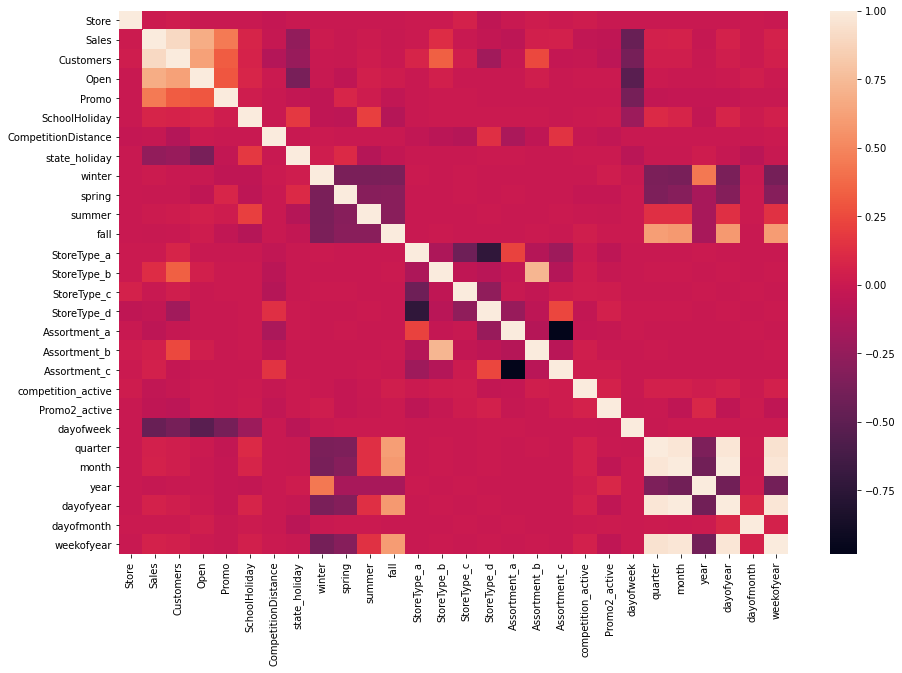

In [7]:
fig = plt.figure(figsize=(15, 10))
sns.heatmap(train_enh.corr())

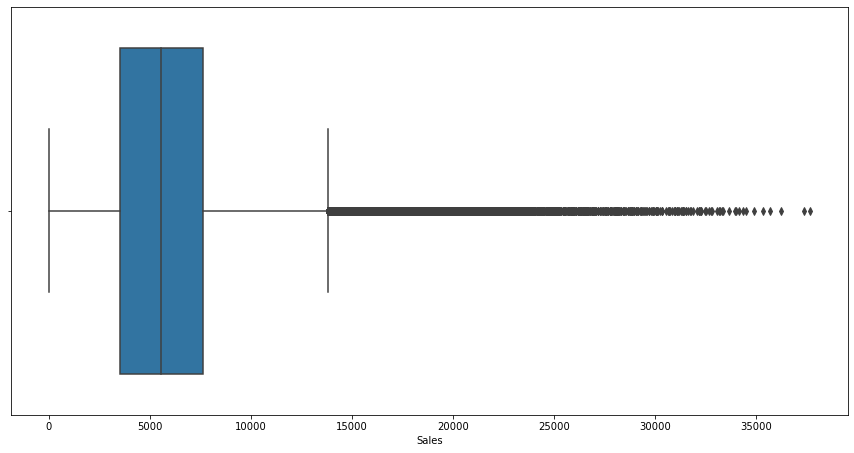

In [8]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(x=train_enh['Sales'])
plt.show()

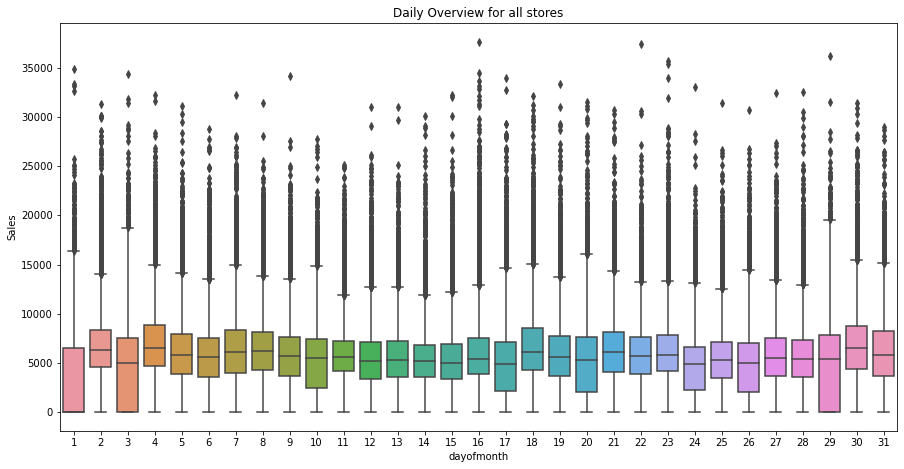

In [9]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(train_enh['dayofmonth'], train_enh['Sales'])
plt.title('Daily Overview for all stores')
plt.show()

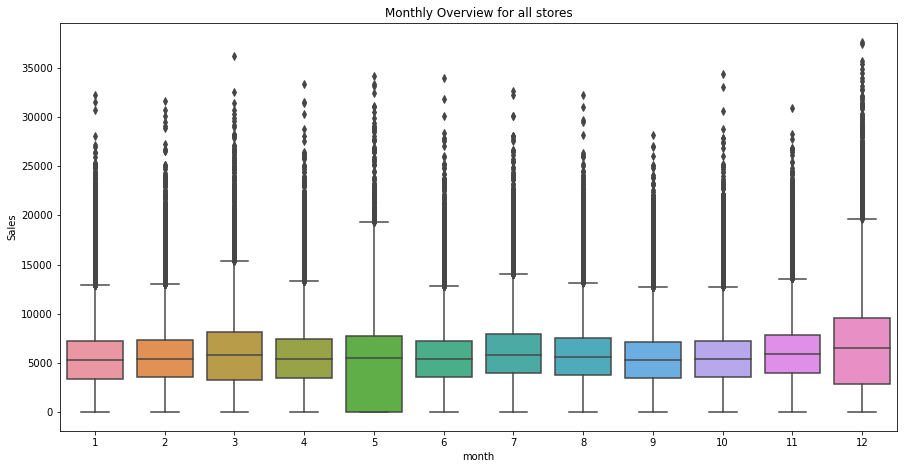

In [10]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(train_enh['month'], train_enh['Sales'])
plt.title('Monthly Overview for all stores')
plt.show()

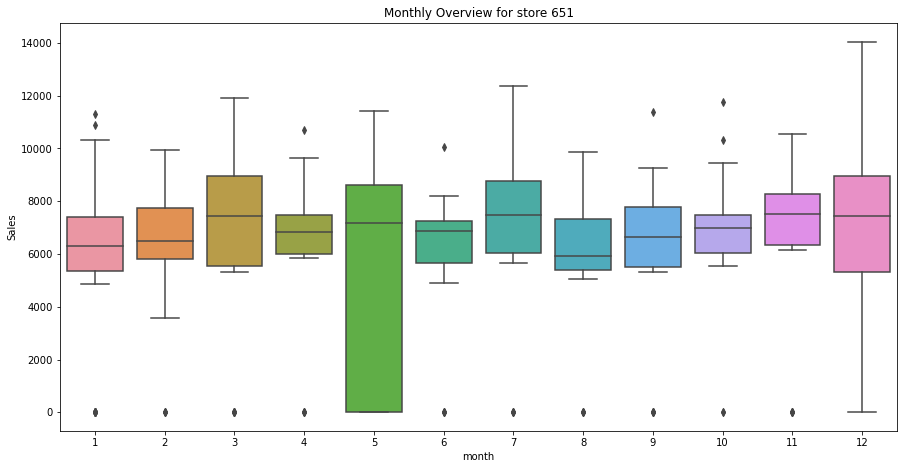

In [11]:
random_store = random.randint(1, 1115)
per_store = train_enh[train_enh['Store'] == random_store]

fig = plt.figure(figsize=(15,7.5))

sns.boxplot(per_store['month'], per_store['Sales'])
plt.title('Monthly Overview for store {}'.format(random_store))
plt.show()

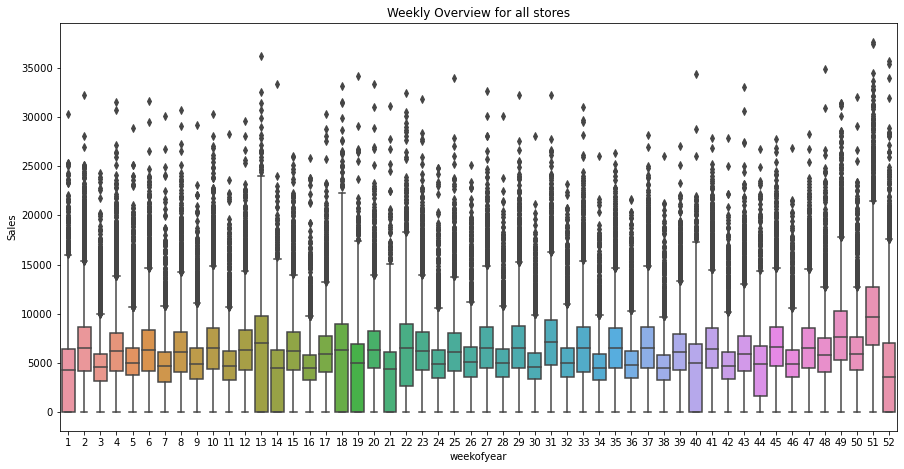

In [12]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(train_enh['weekofyear'], train_enh['Sales'])
plt.title('Weekly Overview for all stores')
plt.show()

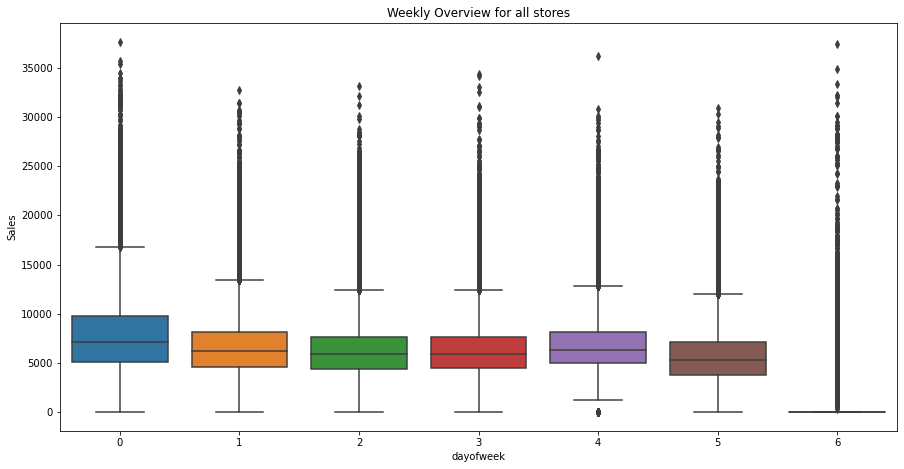

In [13]:
fig = plt.figure(figsize=(15,7.5))

sns.boxplot(train_enh['dayofweek'], train_enh['Sales'])
plt.title('Weekly Overview for all stores')
plt.show()

### Create train and test sets

In [14]:
train_enh.to_pickle("./train.pkl")
val_enh.to_pickle("./val.pkl")

In [44]:
###START HERE AGAIN IF SOMETHING GOT STUCK###

train_enh = pd.read_pickle("./train.pkl")
val_enh = pd.read_pickle("./val.pkl")

In [45]:
#split val_enh dataframe into cv and test set
cv, test = train_val_split(val_enh, '2014-04-30')

In [46]:
def split_dataset(df, label=None):
    mask_0_sales = df['Sales'] != 0    
    df = df.loc[mask_0_sales, :]
    df.set_index('Date', inplace=True)
    X = df
    
    if label:
        X = df.drop(label, axis=1)
        y = df[label]
        
        return X, y

    return X

In [47]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_cv = scaler.transform(X_cv)
scaled_X_test = scaler.transform(X_test)

### Manual Grid Search

In [23]:
def metric(preds, actuals):
    preds = preds.reshape(-1)
    actuals = actuals.reshape(-1)
    assert preds.shape == actuals.shape
    return 100 * np.linalg.norm((actuals - preds) / actuals) / np.sqrt(preds.shape[0])

In [25]:
def grid_search_estimators(train_X, cv_X, train_y, cv_y):
    start = time.time()

    #Grid Search over n_estimators
    for i in [500, 1000]:
        #Initialize XGB
        xgb_reg = xgb.XGBRegressor(n_jobs=-1, n_estimators=i)

        xgb_reg.fit(train_X, train_y)
        predictions = xgb_reg.predict(cv_X)

        result = 'n_estimators: {}'.format(i)
        print(result)
        print('-'*len(result))
        print('Mean Squared Error: {}'.format(str(mean_squared_error(np.array(cv_y), predictions))))
        print('R2 Score: {}'.format(str(r2_score(np.array(cv_y), predictions))))
        print('RMSPE: {}'.format(str(metric(np.array(cv_y), predictions))))
        print('\n')

    print(f'Time: {time.time() - start}')

In [26]:
grid_search_estimators(scaled_X_train, scaled_X_cv, y_train, y_cv)

n_estimators: 500
-----------------
Mean Squared Error: 217893.89964257382
R2 Score: 0.9764823166298405
RMSPE: 6.694045536000169


n_estimators: 1000
------------------
Mean Squared Error: 208763.51846797665
R2 Score: 0.9774677752125052
RMSPE: 6.597285287596596


Time: 970.3785128593445


In [27]:
def grid_search_depth(train_X, cv_X, train_y, cv_y, n_estimators):
    start = time.time()

    for i in range(4, 10, 2):
        xgb_reg = xgb.XGBRegressor(n_jobs=-1, n_estimators=n_estimators, max_depth=i)

        xgb_reg.fit(train_X, train_y)
        predictions = xgb_reg.predict(cv_X)

        result = 'n_estimators: {} | max_depth: {}'.format(n_estimators, i)
        print(result)
        print('-'*len(result))
        print('Mean Squared Error: {}'.format(str(mean_squared_error(np.array(cv_y), predictions))))
        print('R2 Score: {}'.format(str(r2_score(np.array(cv_y), predictions))))
        print('RMSPE: {}'.format(str(metric(np.array(cv_y), predictions))))
        print('\n')

    print(f'Time: {time.time() - start}')

In [28]:
#Grid Search over max_depth (n_estimators = 1000)
grid_search_depth(scaled_X_train, scaled_X_cv, y_train, y_cv, 1000)

n_estimators: 1000 | max_depth: 4
---------------------------------
Mean Squared Error: 239148.67452115944
R2 Score: 0.9741882502676407
RMSPE: 7.23528622170628


n_estimators: 1000 | max_depth: 6
---------------------------------
Mean Squared Error: 208763.51846797665
R2 Score: 0.9774677752125052
RMSPE: 6.597285287596596


n_estimators: 1000 | max_depth: 8
---------------------------------
Mean Squared Error: 203603.1258517647
R2 Score: 0.9780247457372094
RMSPE: 6.713061591060465


Time: 1981.0689227581024


### Predict on test set

In [51]:
#combine scaled_X_train und scaled_X_cv to train model and test on test_X
scaled_X = np.concatenate((scaled_X_train, scaled_X_cv), axis=0)
total_y = np.concatenate((y_train, y_cv), axis=0)

In [52]:
#test XGB with n_estimates = 1000 and max_depth = 6 on test set
xgb_reg = xgb.XGBRegressor(n_jobs=-1, n_estimators=1000, max_depth=6)

xgb_reg.fit(scaled_X, total_y)
predictions = xgb_reg.predict(scaled_X_test)

In [59]:
print('Mean Squared Error: {}'.format(str(mean_squared_error(np.array(y_test), predictions))))
print('R2 Score: {}'.format(str(r2_score(np.array(y_test), predictions))))
print('RMSPE: {}'.format(str(metric(np.array(y_test), predictions))))

Mean Squared Error: 233276.7180704727
R2 Score: 0.9752324424775065
RMSPE: 6.63214609575242


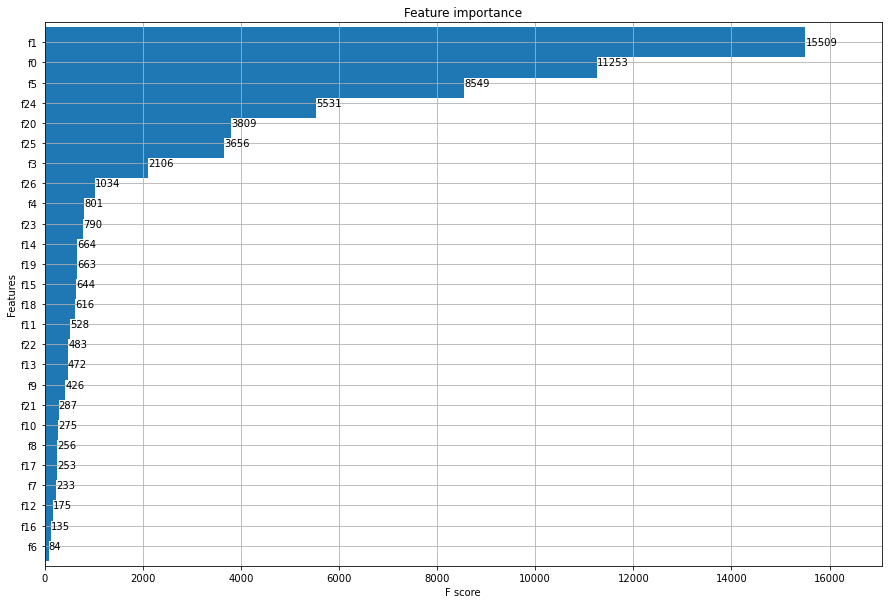

In [53]:
fig, ax = plt.subplots(1,1,figsize=(15, 10))
_ = plot_importance(xgb_reg, ax=ax, height=1.5)

In [54]:
for index, col in enumerate(X_train.columns):
    print('f{}: {}'.format(index, col))

f0: Store
f1: Customers
f2: Open
f3: Promo
f4: SchoolHoliday
f5: CompetitionDistance
f6: state_holiday
f7: winter
f8: spring
f9: summer
f10: fall
f11: StoreType_a
f12: StoreType_b
f13: StoreType_c
f14: StoreType_d
f15: Assortment_a
f16: Assortment_b
f17: Assortment_c
f18: competition_active
f19: Promo2_active
f20: dayofweek
f21: quarter
f22: month
f23: year
f24: dayofyear
f25: dayofmonth
f26: weekofyear


In [56]:
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_cv = pd.concat([X_cv, y_cv], axis=1)
Xy_test = pd.concat([X_test, y_test], axis=1)

<AxesSubplot:xlabel='Date'>

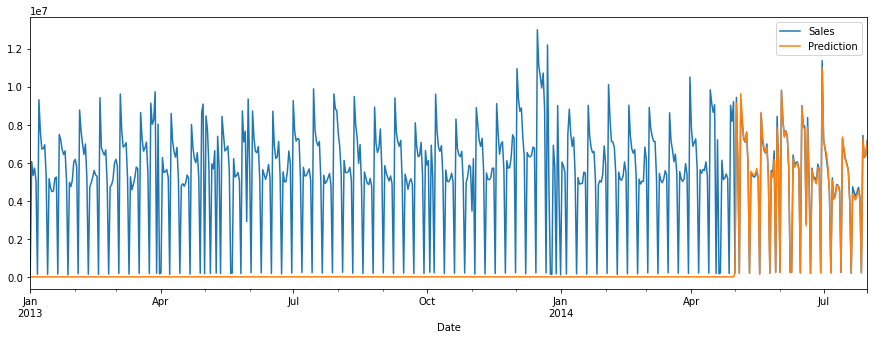

In [57]:
Xy_test['Prediction'] = predictions
df_all = pd.concat([Xy_train, Xy_cv, Xy_test], sort=False)
df_all.groupby('Date').sum()[['Sales','Prediction']].plot(figsize=(15, 5))

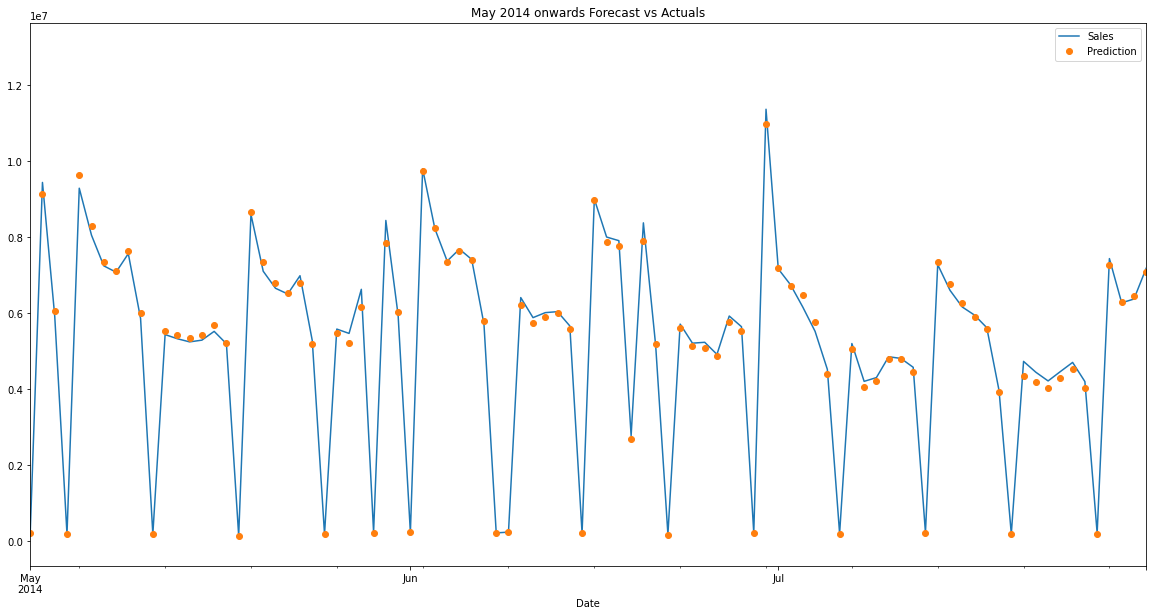

In [62]:
# Plot the forecast with the actual
ax = df_all.groupby('Date').sum()[['Sales', 'Prediction']].plot(style=['-','o'], figsize=(20, 10))
ax.set_xbound(lower='2014-05-01', upper='2014-07-31')
ax.set_title('May 2014 onwards Forecast vs Actuals')
plt.show()

### Grid Search with GridSearchCV

In [30]:
# 
max_depth = [4, 6, 8, 10]         #depth of trees
n_estimators = [100, 500, 1000]   #number of base learners

params = {
    'max_depth': max_depth,
    'n_estimators': n_estimators,
        }

In [35]:
#reverse cv/test split from before + no scaling
X_train, y_train = split_dataset(train_enh, label='Sales')
X_test, y_test = split_dataset(val_enh, label='Sales')

In [40]:
def xgb_gridsearch(X_train, y_train, n_splits=3, n_jobs=-1):
    '''
    Function performs GridSearch using TimeSeries CV
    X_train, y_train
    n_splits=number of splits in TimeSeriesCV; default:5
    n_jobs=default: -1
    '''
    
    model = xgb.XGBRegressor()

    tscv = TimeSeriesSplit(n_splits=n_splits)
    gsearch = GridSearchCV(estimator=model, cv=tscv,
                            param_grid=params, n_jobs=n_jobs)

    gsearch.fit(X_train, y_train)
    
    print("Best params were: {}".format(gsearch.best_params_))
    print('\n')
    
    best_model = gsearch.best_estimator_
    

    print('Mean Squared Error on test set: {}'.format(str(mean_squared_error(np.array(y_test), best_model.predict(X_test)))))
    print('R2 Score on test set: {}'.format(str(r2_score(np.array(y_test), best_model.predict(X_test)))))
    print('RMSPE on test set: {}'.format(str(metric(np.array(y_test), best_model.predict(X_test)))))
    print('\n')
    print('Mean Squared Error on train set: {}'.format(str(mean_squared_error(np.array(y_train), best_model.predict(X_train)))))
    print('R2 Score on train set: {}'.format(str(r2_score(np.array(y_train), best_model.predict(X_train)))))
    print('RMSPE on train set: {}'.format(str(metric(np.array(y_train), best_model.predict(X_train)))))

In [41]:
xgb_gridsearch(X_train, y_train, n_splits=3, n_jobs=-1)

Best params were: {'max_depth': 6, 'n_estimators': 1000}
Mean Squared Error on test set: 230113.94869185673
R2 Score on test set: 0.9753861063496277
RMSPE on test set: 6.635837132885038
Mean Squared Error on test set: 95002.80008602017
R2 Score on test set: 0.9900667423008256
RMSPE on test set: 4.935307627275314
